## Введение.
Проект представляет комплексный анализ нескольких баз данных, которые формируют систему предложения услуг сотовой связи.

# План работы:
1. Посмотреть все имеющиеся данные 
    * Заполнить пропуски и исправить дубликаты.
    * Дополнить таблицы вспомогательными значениями.
    * Привести данные к нужным типам.
2. Для каждого пользователя посчитать:
    * количество сделанных звонков и израсходованных минут разговора по месяцам;
    * количество отправленных сообщений по месяцам;
    * объем израсходованного интернет-трафика по месяцам;
    * помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).
3. Проанализировать данные и выдвинуть первые гипотезы.
4. Подтвердить/опровергнуть гипотезы.
5. Общий вывод.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math
import seaborn as sns

# Часть 1.

## Шаг 1: Знакомство с данными / исправление ошибок и заполнение пропущенных значений.

# Звонки (calls).

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
display(calls.head(20))

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


### Что нужно сделать:
1. Поменять тип данных даты
2. Сделать столбец с месяцем.
3. Узнать причину нулевых значений.

In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

#### Что с нулевыми значениями?


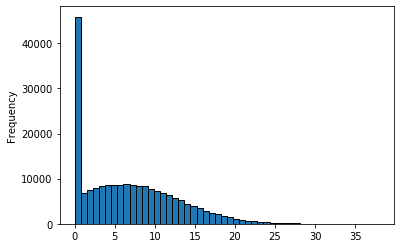

In [5]:
calls['duration'].plot(kind='hist', ec='black', bins=50)

Возможно нулевые значения это округленные значения звонков меньше минуты.


In [6]:
calls.query('0 < duration < 0.5')

,id,call_date,duration,user_id,month
55,1000_55,2018-09-19,0.31,1000,9
65,1000_65,2018-10-28,0.34,1000,10
97,1000_97,2018-10-26,0.33,1000,10
122,1000_122,2018-10-07,0.13,1000,10
135,1000_135,2018-10-25,0.02,1000,10
...,...,...,...,...,...
202318,1498_111,2018-10-17,0.46,1498,10
202322,1498_115,2018-10-02,0.49,1498,10
202438,1499_51,2018-10-08,0.47,1499,10
202452,1499_65,2018-11-30,0.20,1499,11


Что-то ближе к правде, но есть значения самые близкие к нулю. Конечно можно сказать, что звонки были приняты чтобы ответить банальное "Перезвоню позже", но не легче ли на современных смартфонах использовать готовое СМС на сброс номера. + В задании есть замечание, что если пользователь проговорил одну секунду, то засчитывается минута.

Думаю в ноль записывались данные, которые были в сброшенных или не принятых звонках. Поэтому просто уберу эти значения.

In [7]:
calls['duration'] = calls['duration'].replace(0, np.NaN)
calls = calls.dropna()

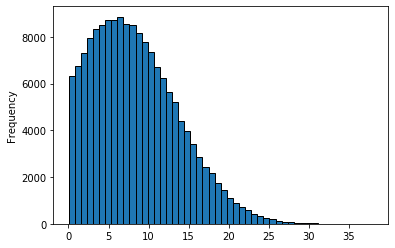

In [8]:
calls['duration'].plot(kind='hist', ec='black', bins=50)

# Интернет (Internet)

In [9]:
internet = pd.read_csv('/datasets/internet.csv')
display(internet.head(20))

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


### Что нужно сделать:
1. привести session_date к соответсвующему типу данных.
2. Добавить столбец с месяцем.

In [11]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [12]:
display(internet.head(20))

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9
5,5,1000_5,399.97,2018-10-02,1000,10
6,6,1000_6,540.08,2018-09-07,1000,9
7,7,1000_7,415.70,2018-07-11,1000,7
8,8,1000_8,505.40,2018-10-08,1000,10
9,9,1000_9,345.54,2018-09-03,1000,9


In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
month           149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.8+ MB


# Сообщения (messages)

In [14]:
messages = pd.read_csv('/datasets/messages.csv')
display(messages.head(20))

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [15]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


### Что нужно сделать:
1. user_id привести к типу int
2. message_date к соответсующему типу данных для даты
3. Добавить столбец с месяцами.


In [16]:
messages['user_id'] = messages['user_id'].astype('int')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [17]:
display(messages.head(20))

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
5,1000_5,2018-06-20,1000,6
6,1000_6,2018-11-19,1000,11
7,1000_7,2018-10-29,1000,10
8,1000_8,2018-06-25,1000,6
9,1000_9,2018-12-18,1000,12


In [18]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
month           123036 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


# Тарифы (tariffs)

In [19]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
display(tariffs.head(20))

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [20]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В тарифах изменять ничего не нужно.

# Пользователи (user_id)

In [21]:
users = pd.read_csv('/datasets/users.csv')
display(users.head(20))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [22]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Что нужно сделать:
1. churn_date исходя из данных о том, что тарифы действовали, можно оставить
2. reg_time и churn_date изменить тип данных
3. Добавить месяца.
4. Добавить информацию по тарифам - какие пользователи к какому тарифу подключены.

In [23]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [24]:
users['month_reg'] = pd.DatetimeIndex(users['reg_date']).month
users['month_churn'] = pd.DatetimeIndex(users['churn_date']).month

In [25]:
display(users.head(20))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month_reg,month_churn
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11,NaN
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,NaN
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8,NaN
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,NaN
5,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,1,NaN
6,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart,2,NaN
7,1007,65,NaT,Москва,Юна,Березина,2018-04-19,smart,4,NaN
8,1008,63,NaT,Челябинск,Рустэм,Пономарёв,2018-12-19,smart,12,NaN
9,1009,24,NaT,Пермь,Василиса,Блинова,2018-03-22,smart,3,NaN


In [26]:
for item in [calls, internet, messages, tariffs, users]:
    item.info()
    item.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 5 columns):
id           162994 non-null object
call_date    162994 non-null datetime64[ns]
duration     162994 non-null float64
user_id      162994 non-null int64
month        162994 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 7.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
month           149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
id              123036 non-null object
message_date    123036 non-null datetime64

#### Как видно все поставленные задачи на шаг выполнены:
1. Тип данных, относящихся к датам, приобрели соответствующие типы данных.
2. Нулевые показатели в длительности данных были убраны, т.к. их отсутствие не повлияет на дальнейшую работу, а их наличие будет отвлекать.
3. Дата прекращения пользования тарифами не была изменена, т.к. нет достоверных источников информации, а потому всё осталось на своих местах.
4. Были добавлены столбцы с меясцами в таблицы.
5. В таблицу с пользователями были добавлены тарифы, которыми они пользуются.

# Шаг 2. Подсчеты для пользователей.

### 1. Количество сделанных звонков и израсходованных минут разговора по месяцам

Округляю минуты и мегабайты в большую сторону:

In [27]:
calls['duration']=calls['duration'].apply(np.ceil)
internet['mb_used']=internet['mb_used'].apply(np.ceil)

In [28]:
num_of_calls = calls.groupby(['user_id','month'])['duration'].agg(['count', 'sum'])
num_of_calls.head(50)

count    sum
user_id month              
1000    5         17  159.0
        6         28  172.0
        7         41  340.0
        8         42  408.0
        9         46  466.0
        10        44  350.0
        11        37  338.0
        12        38  333.0
1001    11        45  430.0
        12        47  414.0
1002    6         14  117.0
        7         21  214.0
        8         37  289.0
        9         25  206.0
        10        24  212.0
        11        25  243.0
        12        27  236.0
1003    8         43  380.0
        9        105  961.0
        10        97  855.0
        11        95  824.0
        12        88  802.0
1004    5          7   35.0
        6         25  171.0
        7         20  135.0
        8         18  137.0
        9         18  117.0
        10        21  145.0
        11        15  117.0
        12        15  130.0
1005    1         11   95.0
        2         55  456.0
        3         63  606.0
        4         77  712.0
        5         62  595.0
        6         69  612.0
        7         62  569.0
        8         64  619.0
        9         57  479.0
        10        78  723.0
        11        60  547.0
        12        63  592.0
1006    2          3   42.0
        3         36  286.0
        4         38  356.0
        5         45  370.0
        6         48  478.0
        7         38  316.0
        8         32  275.0
        9         47  360.0

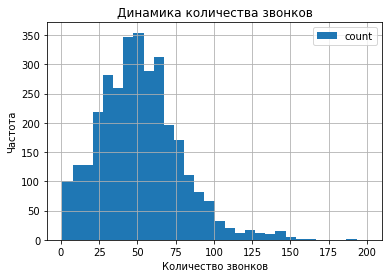

In [29]:
#Гистограмма по количеству звонков.
num_of_calls.plot(y = 'count', kind = 'hist', bins = 30, grid = True, range = (1,200))
plt.title('Динамика количества звонков')
plt.xlabel('Количество звонков')
plt.ylabel('Частота')
plt.show()

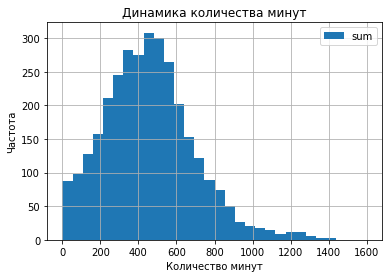

In [30]:
#Гистограмма по количеству минут.
num_of_calls.plot(y = 'sum', kind = 'hist', bins = 30, grid = True, range = (1,1600))
plt.title('Динамика количества минут')
plt.xlabel('Количество минут')
plt.ylabel('Частота')
plt.show()

### 2. Количество отправленных сообщений по месяцам

In [31]:
num_of_messages = messages.groupby(['user_id', 'month'])['id'].count()
display(num_of_messages.head(20))

user_id  month
1000     5        22
         6        60
         7        75
         8        81
         9        57
         10       73
         11       58
         12       70
1002     6         4
         7        11
         8        13
         9         4
         10       10
         11       16
         12       12
1003     8        37
         9        91
         10       83
         11       94
         12       75
Name: id, dtype: int64

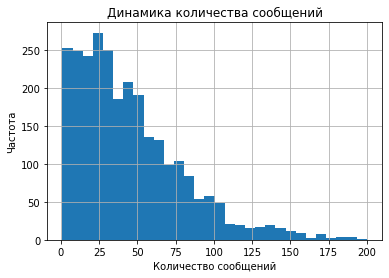

In [32]:
#Гистограмма по количеству сообщений.
num_of_messages.plot(y = 'count', kind = 'hist', bins = 30, grid = True, range = (1,200))
plt.title('Динамика количества сообщений')
plt.xlabel('Количество сообщений')
plt.ylabel('Частота')
plt.show()

### 3. объем израсходованного интернет-трафика по месяцам

In [33]:
num_of_internet = internet.groupby(['user_id', 'month']).sum()['mb_used']
display(num_of_internet.head(20))

user_id  month
1000     5         2256.0
         6        23257.0
         7        14016.0
         8        14070.0
         9        14581.0
         10       14717.0
         11       14768.0
         12        9827.0
1001     11       18452.0
         12       14053.0
1002     6        10871.0
         7        17601.0
         8        20347.0
         9        16712.0
         10       13905.0
         11       18610.0
         12       18137.0
1003     8         8571.0
         9        12479.0
         10       14779.0
Name: mb_used, dtype: float64

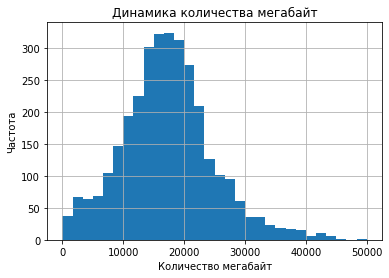

In [34]:
#Гистограмма по количеству мегабайт
num_of_internet.plot(y = 'mb_used', kind = 'hist', bins = 30, grid = True, range = (1, 50000))
plt.title('Динамика количества мегабайт')
plt.xlabel('Количество мегабайт')
plt.ylabel('Частота')
plt.show()

### Объединю таблицы

In [35]:
common_numbers = pd.concat([num_of_calls, num_of_messages, num_of_internet], axis=1)
common_numbers = common_numbers.reset_index()
common_numbers.head()


,user_id,month,count,sum,id,mb_used
0,1000,5,17.0,159.0,22.0,2256.0
1,1000,6,28.0,172.0,60.0,23257.0
2,1000,7,41.0,340.0,75.0,14016.0
3,1000,8,42.0,408.0,81.0,14070.0
4,1000,9,46.0,466.0,57.0,14581.0


+Добавлю столбец с наименованием тарифа.

In [36]:
map_to_fill_tariff = dict(pd.Series(users['tariff'].values, index=users['user_id']))
common_numbers['Тариф'] = common_numbers['user_id'].map(map_to_fill_tariff)
map_to_fill_city = dict(pd.Series(users['city'].values, index=users['user_id']))
common_numbers['Город'] = common_numbers['user_id'].map(map_to_fill_city)

### Общий вид таблицы:

In [37]:
common_numbers.columns=['User_id','Месяц','Количество звонков','Количество минут','Количество сообщений','Количество мегабайт','Тариф','Город']
common_numbers.sort_values(by=['User_id', 'Месяц']).head(20)

,User_id,Месяц,Количество звонков,Количество минут,Количество сообщений,Количество мегабайт,Тариф,Город
0,1000,5,17.0,159.0,22.0,2256.0,ultra,Краснодар
1,1000,6,28.0,172.0,60.0,23257.0,ultra,Краснодар
2,1000,7,41.0,340.0,75.0,14016.0,ultra,Краснодар
3,1000,8,42.0,408.0,81.0,14070.0,ultra,Краснодар
4,1000,9,46.0,466.0,57.0,14581.0,ultra,Краснодар
5,1000,10,44.0,350.0,73.0,14717.0,ultra,Краснодар
6,1000,11,37.0,338.0,58.0,14768.0,ultra,Краснодар
7,1000,12,38.0,333.0,70.0,9827.0,ultra,Краснодар
8,1001,11,45.0,430.0,NaN,18452.0,smart,Москва
9,1001,12,47.0,414.0,NaN,14053.0,smart,Москва


In [38]:
common_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 8 columns):
User_id                 3214 non-null int64
Месяц                   3214 non-null int64
Количество звонков      3168 non-null float64
Количество минут        3168 non-null float64
Количество сообщений    2717 non-null float64
Количество мегабайт     3203 non-null float64
Тариф                   3214 non-null object
Город                   3214 non-null object
dtypes: float64(4), int64(2), object(2)
memory usage: 201.0+ KB


Есть пропущенные значения в количественных значениях, нужно проверить есть ли пользователи, которые ни разу не пользовались какими-либо предсталенными услугами.

In [39]:
common_numbers[(common_numbers['Количество мегабайт'].isnull()) & (common_numbers['Количество сообщений'].isnull()) &
                 (common_numbers['Количество минут'].isnull())]

,User_id,Месяц,Количество звонков,Количество минут,Количество сообщений,Количество мегабайт,Тариф,Город


Пусто, наверное, каждый пользователь был активен в рамках предпочтительных форм связи. В таком случае, на местах пропусков просто поставлю нули.

In [40]:
common_numbers = common_numbers.fillna(0)
common_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 8 columns):
User_id                 3214 non-null int64
Месяц                   3214 non-null int64
Количество звонков      3214 non-null float64
Количество минут        3214 non-null float64
Количество сообщений    3214 non-null float64
Количество мегабайт     3214 non-null float64
Тариф                   3214 non-null object
Город                   3214 non-null object
dtypes: float64(4), int64(2), object(2)
memory usage: 201.0+ KB


### 3. Выручка с каждого клиента.

#### Абонетская плата.

In [41]:
month_price = {'smart': 550, 'ultra': 1950}
common_numbers['Аб. плата, руб.'] = common_numbers['Тариф'].map(month_price)

In [42]:
common_numbers.head(100)

,User_id,Месяц,Количество звонков,Количество минут,Количество сообщений,Количество мегабайт,Тариф,Город,"Аб. плата, руб."
0,1000,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,1950
1,1000,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,1950
2,1000,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,1950
3,1000,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,1950
4,1000,9,46.0,466.0,57.0,14581.0,ultra,Краснодар,1950
...,...,...,...,...,...,...,...,...,...
95,1012,10,43.0,451.0,13.0,29108.0,smart,Санкт-Петербург,550
96,1012,11,19.0,206.0,25.0,22546.0,smart,Санкт-Петербург,550
97,1012,12,35.0,356.0,15.0,14026.0,smart,Санкт-Петербург,550
98,1013,11,41.0,369.0,17.0,9790.0,ultra,Иваново,1950


Далее нужно найти показатели выходящие за рамки предложений по тарифам, чтобы в дальнейшем найти выручку. Для этого нужно:
1. Найти превышения по лимитам в мобильных услугах - нужно вычислить через функции и создать новые столбцы.
2. Потом найти их финальные суммы переплат по тарифам.
3. И в конце суммировать абонетскую плату и переплаты.

Функция для подсчета превышений по услугам:

In [43]:
def calls_over(row):
    if row['Тариф'] == 'smart':
        result = row['Количество минут'] - 500
        return np.where(result > 0, result, 0)
    else:
        result = row['Количество минут'] - 3000
        return np.where(result > 0, result, 0)
    
    
def messages_over(row):
    if row['Тариф'] == 'smart':
        result = row['Количество сообщений'] - 50
        return np.where(result > 0, result, 0)
    else:
        result =  row['Количество сообщений'] - 1000
        return np.where(result > 0, result, 0)
    

def mb_over(row):
    if row['Тариф'] == 'smart':
        result = row['Количество мегабайт'] - 15 * 1024
        return np.where(result > 0, result, 0)
    else:
        result = row['Количество мегабайт'] - 30 * 1024
        return np.where(result > 0, result, 0)
    
    
def month_revenue(row):
    sum_per_month = 0
    if row['Тариф'] == 'smart':
        sum_per_month += np.ceil(row['Минуты: больше лимита']) * 3
        sum_per_month += row['Сообщений: больше лимита'] * 3
        sum_per_month += np.ceil(row['Мегабайт: больше лимита']/1024) * 200
        return sum_per_month
    
    else:
        sum_per_month += np.ceil(row['Минуты: больше лимита']) * 1
        sum_per_month += row['Сообщений: больше лимита'] * 1
        sum_per_month += np.ceil(row['Мегабайт: больше лимита']/1024) * 150
        return sum_per_month

Теперь посчитанные значения нужно добавить в таблицу:

In [44]:
common_numbers['Минуты: больше лимита'] = common_numbers.apply(calls_over, axis=1)
common_numbers['Сообщений: больше лимита'] = common_numbers.apply(messages_over, axis=1)
common_numbers['Мегабайт: больше лимита'] = common_numbers.apply(mb_over, axis=1)

common_numbers['Переплата в рублях'] = common_numbers.apply(month_revenue, axis=1)

for column in ['Минуты: больше лимита', 'Мегабайт: больше лимита']:
    common_numbers[column] = common_numbers[column].astype('float')

for column in ['Сообщений: больше лимита', 'Переплата в рублях']:
    common_numbers[column] = common_numbers[column].astype('int')

In [45]:
common_numbers.head(100)

,User_id,Месяц,Количество звонков,Количество минут,Количество сообщений,Количество мегабайт,Тариф,Город,"Аб. плата, руб.",Минуты: больше лимита,Сообщений: больше лимита,Мегабайт: больше лимита,Переплата в рублях
0,1000,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,1950,0.0,0,0.0,0
1,1000,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,1950,0.0,0,0.0,0
2,1000,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,1950,0.0,0,0.0,0
3,1000,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,1950,0.0,0,0.0,0
4,1000,9,46.0,466.0,57.0,14581.0,ultra,Краснодар,1950,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1012,10,43.0,451.0,13.0,29108.0,smart,Санкт-Петербург,550,0.0,0,13748.0,2800
96,1012,11,19.0,206.0,25.0,22546.0,smart,Санкт-Петербург,550,0.0,0,7186.0,1600
97,1012,12,35.0,356.0,15.0,14026.0,smart,Санкт-Петербург,550,0.0,0,0.0,0
98,1013,11,41.0,369.0,17.0,9790.0,ultra,Иваново,1950,0.0,0,0.0,0


In [46]:
common_numbers['Выручка в рублях'] = common_numbers['Аб. плата, руб.'] + common_numbers['Переплата в рублях']

##### Финальная таблица:

In [47]:
common_numbers.head(100)

,User_id,Месяц,Количество звонков,Количество минут,Количество сообщений,Количество мегабайт,Тариф,Город,"Аб. плата, руб.",Минуты: больше лимита,Сообщений: больше лимита,Мегабайт: больше лимита,Переплата в рублях,Выручка в рублях
0,1000,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
1,1000,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
2,1000,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
3,1000,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
4,1000,9,46.0,466.0,57.0,14581.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1012,10,43.0,451.0,13.0,29108.0,smart,Санкт-Петербург,550,0.0,0,13748.0,2800,3350
96,1012,11,19.0,206.0,25.0,22546.0,smart,Санкт-Петербург,550,0.0,0,7186.0,1600,2150
97,1012,12,35.0,356.0,15.0,14026.0,smart,Санкт-Петербург,550,0.0,0,0.0,0,550
98,1013,11,41.0,369.0,17.0,9790.0,ultra,Иваново,1950,0.0,0,0.0,0,1950


### Вывод по Шагу №2.
1. Округлил минуты и мегабайты в большую сторону.
2. Подсчитал количественные показатели по пользователям.
3. Объеденил всё в единую таблицу.
4. Добавил столбец с городом, тарифом и абонетской платы.
5. Составил функцию по превышению лимита по услугам связи для каждого тарифа.
6. Добавил всё в изначальную таблицу.

# Шаг 3. Анализ Данных.

#### Что нужно сделать:
1. Найти сколько нужно количественных показателей для пользоватлей (минут, сообщений, мб).
2. Посчитать среднее количество, дисперсию и стандартное отклонение.
3. На основе расчетов построить графики для наглядности. + Сделать выводы.

### Средние значения.

#### Тариф "Ультра"

In [48]:
mean_ultra=(common_numbers
     .query('Тариф=="ultra"')
     .pivot_table(index='Месяц',values=('Количество мегабайт','Количество минут','Количество сообщений'),aggfunc=('mean'))    
)

In [49]:
mean_ultra.set_axis(['Среднее количество мегабайт','Среднее количество минут','Среднее количество сообщений'],axis='columns',inplace=True)
mean_ultra

,Среднее количество мегабайт,Среднее количество минут,Среднее количество сообщений
Месяц,,,
1,13153.555556,428.111111,33.777778
2,11786.958333,297.125000,21.958333
3,17551.972973,489.648649,32.297297
4,16843.800000,458.018182,31.563636
5,19381.194030,510.328358,37.850746
6,18942.238095,479.702381,41.726190
7,20514.648352,545.791209,49.846154
8,19594.065421,510.775701,48.439252
9,19222.208696,539.443478,52.286957


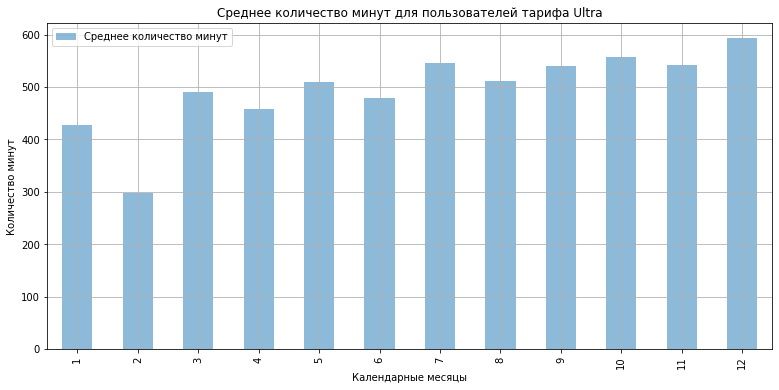

In [50]:
mean_ultra.plot(y='Среднее количество минут',grid=True,figsize=(13,6),style='o-',kind='bar',alpha=0.5)
plt.title('Среднее количество минут для пользователей тарифа Ultra')
plt.xlabel('Календарные месяцы')
plt.ylabel('Количество минут')
plt.show()

###### Вывод:
1. Самый низкий период активности для пользователей тарифа "Ультра" можно выделить январь и самый низкий по активности февраль.
2. Самые высокие: июль (разгар отпусков), декабрь (предпраздничные дни, здесь, скорее всего, соверешается огромное количество рабочих звонков).
3. В остальные месяцы пользователи стабильно используют от 400 до 600 минут.

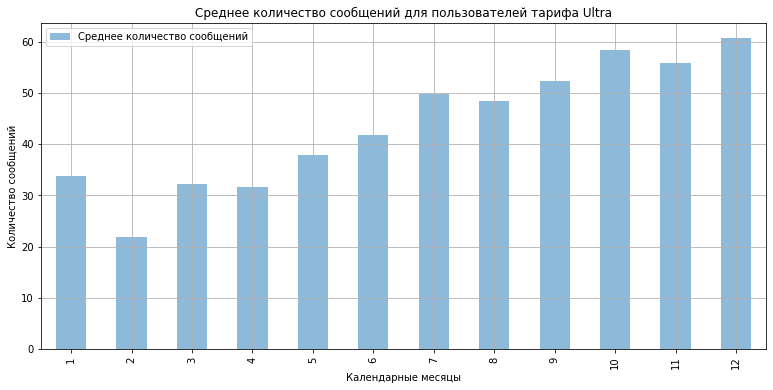

In [51]:
mean_ultra.plot(y='Среднее количество сообщений',grid=True,figsize=(13,6),style='o-',kind='bar',alpha=0.5)
plt.title('Среднее количество сообщений для пользователей тарифа Ultra')
plt.xlabel('Календарные месяцы')
plt.ylabel('Количество сообщений')
plt.show()

###### Вывод:
1. Существует ощутимый динамизм в отправке сообщений.
2. Самый низкий период активности - февраль, самый короткий месяц.
3. Самый активный - декабрь, люди активно поздравляют друг друга, ну и про работу не забывают. 
4. В среднем отправлюят от 30 до 60 сообщений.

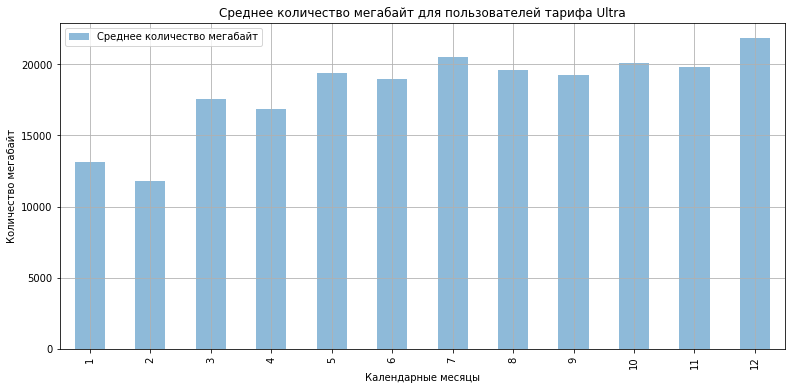

In [52]:
mean_ultra.plot(y='Среднее количество мегабайт',grid=True,figsize=(13,6),style='o-',kind='bar',alpha=0.5)
plt.title('Среднее количество мегабайт для пользователей тарифа Ultra')
plt.xlabel('Календарные месяцы')
plt.ylabel('Количество мегабайт')
plt.show()

##### Вывод:
1. Восходящая динамика, думаю в Январе мало кто сидит в мобильном интернете, т.к. многие сидят дома (используют домашний интернет) либо активно проводят время.
2. В Феврале мало пользуются интернетом - самый короткий месяц, начинают активно работать после января.
3. Июль и Октябрь - странно, но думаю здесь - в июле все в отпусках, а в октябре те, кто не успел отдохнуть в июле.
4. Девабрь пиковый месяц - всё также работа, да праздники.

#### Тариф "Смарт"

In [53]:
mean_smart=(common_numbers
     .query('Тариф=="smart"')
     .pivot_table(index='Месяц',values=('Количество мегабайт','Количество минут','Количество сообщений'),aggfunc=('mean'))    
)

In [54]:
mean_smart.set_axis(['Среднее количество мегабайт','Среднее количество минут','Среднее количество сообщений'],axis='columns',inplace=True)
mean_smart

,Среднее количество мегабайт,Среднее количество минут,Среднее количество сообщений
Месяц,,,
1,8524.441176,203.852941,18.235294
2,11611.396552,298.689655,24.086207
3,15123.857143,390.051948,31.857143
4,13479.482143,367.133929,30.741071
5,15825.198582,387.361702,33.773050
6,15814.768293,395.640244,33.402439
7,15763.512438,408.353234,33.751244
8,16632.174468,421.468085,33.638298
9,16324.526923,428.611538,33.638462


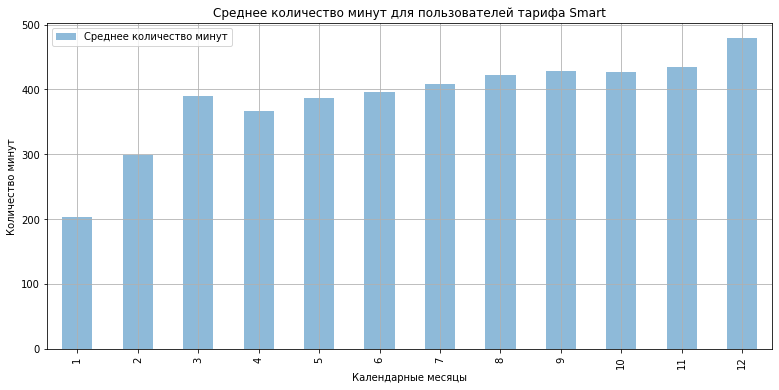

In [55]:
mean_smart.plot(y='Среднее количество минут',grid=True,figsize=(13,6),style='o-',kind='bar',alpha=0.5)
plt.title('Среднее количество минут для пользователей тарифа Smart')
plt.xlabel('Календарные месяцы')
plt.ylabel('Количество минут')
plt.show()

##### Вывод:
1. Здесь все более-менее плавно, но январь и февраль тоже самые мало активные месяцы.
2. Опять декабрь пиковый месяц для звонков, а вот здесь январь самый менее активный.

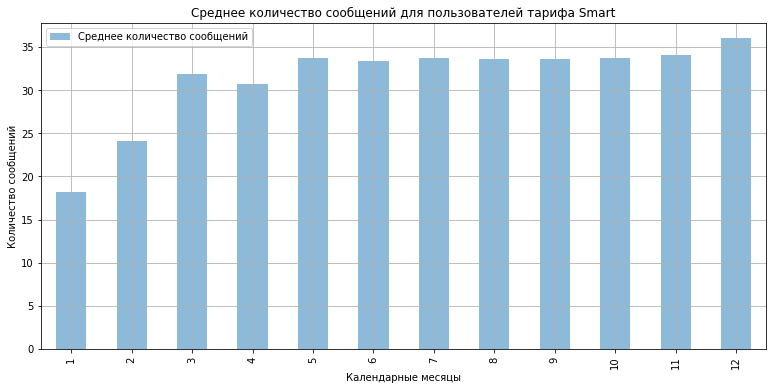

In [56]:
mean_smart.plot(y='Среднее количество сообщений',grid=True,figsize=(13,6),style='o-',kind='bar',alpha=0.5)
plt.title('Среднее количество сообщений для пользователей тарифа Smart')
plt.xlabel('Календарные месяцы')
plt.ylabel('Количество сообщений')
plt.show()

##### Вывод:
1. В целом, ровные показатели.
2. Менее активный - январь, более активный - декабрь.
3. Диапозон использование СМС ~от 16 до чуть больше 35.

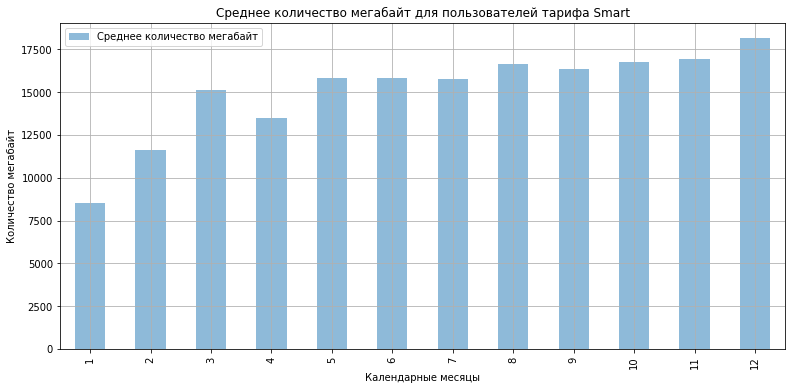

In [57]:
mean_smart.plot(y='Среднее количество мегабайт',grid=True,figsize=(13,6),style='o',kind='bar',alpha=0.5)
plt.title('Среднее количество мегабайт для пользователей тарифа Smart')
plt.xlabel('Календарные месяцы')
plt.ylabel('Количество мегабайт')
plt.show()

##### Вывод:
1. Средний диапозон от 20 гб. Начиная с мая люди всё чаще выходят за пороги лимита в 15 гб.
3. Показатели ровные, но Январь и Февраль также мало показателей, как в других видах свзяи и в тарифе "Ультра".

### Дисперсия и отклонение.
Буду также считать по тарифам и услугам. Сначала тариф Ультра, потом тариф Смарт.

### Дисперсия.

In [58]:
all_ultra = common_numbers.query('Тариф=="ultra"')
all_ultra.head(100)

,User_id,Месяц,Количество звонков,Количество минут,Количество сообщений,Количество мегабайт,Тариф,Город,"Аб. плата, руб.",Минуты: больше лимита,Сообщений: больше лимита,Мегабайт: больше лимита,Переплата в рублях,Выручка в рублях
0,1000,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
1,1000,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
2,1000,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
3,1000,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
4,1000,9,46.0,466.0,57.0,14581.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1057,12,99.0,837.0,28.0,21994.0,ultra,Москва,1950,0.0,0,0.0,0,1950
382,1060,11,38.0,371.0,12.0,12718.0,ultra,Калуга,1950,0.0,0,0.0,0,1950
383,1060,12,144.0,1233.0,52.0,43973.0,ultra,Калуга,1950,0.0,0,13253.0,1950,3900
392,1063,4,67.0,581.0,0.0,17075.0,ultra,Тула,1950,0.0,0,0.0,0,1950


##### Дисперсия тарифа Ультра

In [59]:
#Минуты
disp_all_ultra_calls=all_ultra.pivot_table(index='Месяц',values='Количество минут',aggfunc=(np.var))
disp_all_ultra_calls.head(100)


,Количество минут
Месяц,
1,72769.361111
2,87919.679348
3,111384.900901
4,71653.870034
5,83870.193578
6,91535.946500
7,94322.278144
8,97956.496385
9,105716.775286


In [60]:
# Сообщения
disp_all_ultra_sms=all_ultra.pivot_table(index='Месяц',values='Количество сообщений',aggfunc=(np.var))
disp_all_ultra_sms.head(100)

,Количество сообщений
Месяц,
1,940.694444
2,716.824275
3,1732.381381
4,1407.287542
5,1624.644052
6,1986.297619
7,2372.042735
8,2171.739199
9,2152.855530


In [61]:
#Мегабайты
disp_all_ultra_mb=all_ultra.pivot_table(index='Месяц',values='Количество мегабайт',aggfunc=(np.var))
disp_all_ultra_mb.head(100)

,Количество мегабайт
Месяц,
1,4.722641e+07
2,1.135150e+08
3,1.201640e+08
4,9.462393e+07
5,1.011158e+08
6,8.652248e+07
7,1.014776e+08
8,1.099560e+08
9,9.014880e+07


##### Дисперсия по тарифу Смарт.

In [62]:
all_smart = common_numbers.query('Тариф=="smart"')
all_smart.head(100)

,User_id,Месяц,Количество звонков,Количество минут,Количество сообщений,Количество мегабайт,Тариф,Город,"Аб. плата, руб.",Минуты: больше лимита,Сообщений: больше лимита,Мегабайт: больше лимита,Переплата в рублях,Выручка в рублях
8,1001,11,45.0,430.0,0.0,18452.0,smart,Москва,550,0.0,0,3092.0,800,1350
9,1001,12,47.0,414.0,0.0,14053.0,smart,Москва,550,0.0,0,0.0,0,550
10,1002,6,14.0,117.0,4.0,10871.0,smart,Стерлитамак,550,0.0,0,0.0,0,550
11,1002,7,21.0,214.0,11.0,17601.0,smart,Стерлитамак,550,0.0,0,2241.0,600,1150
12,1002,8,37.0,289.0,13.0,20347.0,smart,Стерлитамак,550,0.0,0,4987.0,1000,1550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,1017,6,36.0,341.0,0.0,17309.0,smart,Краснодар,550,0.0,0,1949.0,400,950
121,1017,7,47.0,461.0,0.0,18968.0,smart,Краснодар,550,0.0,0,3608.0,800,1350
122,1017,8,52.0,389.0,0.0,16681.0,smart,Краснодар,550,0.0,0,1321.0,400,950
123,1017,9,37.0,366.0,0.0,18232.0,smart,Краснодар,550,0.0,0,2872.0,600,1150


In [63]:
#Минуты
disp_all_smart_calls=all_smart.pivot_table(index='Месяц',values='Количество минут',aggfunc=(np.var))
disp_all_smart_calls.head(100)

,Количество минут
Месяц,
1,23787.341355
2,36412.287961
3,36823.155161
4,34778.207127
5,34820.061094
6,30742.918861
7,32250.269602
8,34793.583379
9,33535.342723


In [64]:
# Сообщения
disp_all_smart_sms=all_smart.pivot_table(index='Месяц',values='Количество сообщений',aggfunc=(np.var))
disp_all_smart_sms.head(100)

,Количество сообщений
Месяц,
1,262.367201
2,473.097701
3,718.492481
4,602.139559
5,730.990983
6,806.806374
7,799.887811
8,838.257501
9,790.617820


In [65]:
#Мегабайты
disp_all_smart_mb=all_smart.pivot_table(index='Месяц',values='Количество мегабайт',aggfunc=(np.var))
disp_all_smart_mb.head(100)

,Количество мегабайт
Месяц,
1,4.162621e+07
2,3.911935e+07
3,3.405260e+07
4,3.254736e+07
5,3.582236e+07
6,3.361642e+07
7,3.486110e+07
8,3.136352e+07
9,2.706215e+07


### Стандартное отклонение.

#### Отклонения по тарифу Ультра.

In [66]:
#Минуты
disp_all_ultra_calls['sigma']=disp_all_ultra_calls.apply(np.sqrt)


In [67]:
#Сообщения
disp_all_ultra_sms['sigma']=disp_all_ultra_sms.apply(np.sqrt)


In [68]:
#Мегабайты
disp_all_ultra_mb['sigma']=disp_all_ultra_mb.apply(np.sqrt)


Сформирую общую таблицу Ультра

In [69]:
disp_all_ultra_calls.set_axis(['dispersion_call','sigma_call'],axis='columns',inplace=True)
disp_all_ultra_sms.set_axis(['dispersion_message','sigma_message'],axis='columns',inplace=True)
disp_all_ultra_mb.set_axis(['dispersion_mb','sigma_mb'],axis='columns',inplace=True)

In [70]:
disp_all_ultra_calls=disp_all_ultra_calls.merge(disp_all_ultra_sms,on='Месяц')
disp_all_ultra_calls=disp_all_ultra_calls.merge(disp_all_ultra_mb,on='Месяц')

In [71]:
mean_ultra=mean_ultra.merge(disp_all_ultra_calls,on='Месяц')

#### Общая таблица для тарифа Ультра

In [72]:
mean_ultra.set_axis(['Среднее количество мегабайт','Среднее количество минут','Среднее количество сообщений','Дисперсия минут','Отклонение в минутах','Дисперсия сообщений','Отклонение сообщений','Дисперсия мб','Отклонение мб'],axis='columns',inplace=True)
mean_ultra.head(12)

,Среднее количество мегабайт,Среднее количество минут,Среднее количество сообщений,Дисперсия минут,Отклонение в минутах,Дисперсия сообщений,Отклонение сообщений,Дисперсия мб,Отклонение мб
Месяц,,,,,,,,,
1,13153.555556,428.111111,33.777778,72769.361111,269.757968,940.694444,30.670742,4.722641e+07,6872.147046
2,11786.958333,297.125000,21.958333,87919.679348,296.512528,716.824275,26.773574,1.135150e+08,10654.343346
3,17551.972973,489.648649,32.297297,111384.900901,333.743765,1732.381381,41.621886,1.201640e+08,10961.936316
4,16843.800000,458.018182,31.563636,71653.870034,267.682405,1407.287542,37.513831,9.462393e+07,9727.483304
5,19381.194030,510.328358,37.850746,83870.193578,289.603511,1624.644052,40.306874,1.011158e+08,10055.634106
6,18942.238095,479.702381,41.726190,91535.946500,302.549081,1986.297619,44.567899,8.652248e+07,9301.745817
7,20514.648352,545.791209,49.846154,94322.278144,307.119322,2372.042735,48.703621,1.014776e+08,10073.606689
8,19594.065421,510.775701,48.439252,97956.496385,312.980026,2171.739199,46.601923,1.099560e+08,10485.992263
9,19222.208696,539.443478,52.286957,105716.775286,325.141162,2152.855530,46.398874,9.014880e+07,9494.672266


#### Отклонения по тарифу Смарт

In [73]:
#Минуты
disp_all_smart_calls['sigma']=disp_all_smart_calls.apply(np.sqrt) 

In [74]:
#Сообщения
disp_all_smart_sms['sigma']=disp_all_smart_sms.apply(np.sqrt)

In [75]:
#Мегабайты
disp_all_smart_mb['sigma']=disp_all_smart_mb.apply(np.sqrt)

Сформирую общую таблицу для Смарт

In [76]:
disp_all_smart_calls.set_axis(['dispersion_call','sigma_call'],axis='columns',inplace=True)
disp_all_smart_sms.set_axis(['dispersion_message','sigma_message'],axis='columns',inplace=True)
disp_all_smart_mb.set_axis(['dispersion_mb','sigma_mb'],axis='columns',inplace=True)

In [77]:
disp_all_smart_calls=disp_all_smart_calls.merge(disp_all_smart_sms,on='Месяц')
disp_all_smart_calls=disp_all_smart_calls.merge(disp_all_smart_mb,on='Месяц')

In [78]:
mean_smart=mean_smart.merge(disp_all_smart_calls,on='Месяц')

#### Общая таблица для тарифа Смарт

In [79]:
mean_smart.set_axis(['Среднее количество мегабайт','Среднее количество минут','Среднее количество сообщений','Дисперсия минут','Отклонение в минутах','Дисперсия сообщений','Отклонение сообщений','Дисперсия мб','Отклонение мб'],axis='columns',inplace=True)
mean_smart.head(12)

,Среднее количество мегабайт,Среднее количество минут,Среднее количество сообщений,Дисперсия минут,Отклонение в минутах,Дисперсия сообщений,Отклонение сообщений,Дисперсия мб,Отклонение мб
Месяц,,,,,,,,,
1,8524.441176,203.852941,18.235294,23787.341355,154.231454,262.367201,16.197753,4.162621e+07,6451.837940
2,11611.396552,298.689655,24.086207,36412.287961,190.820041,473.097701,21.750809,3.911935e+07,6254.546293
3,15123.857143,390.051948,31.857143,36823.155161,191.893604,718.492481,26.804710,3.405260e+07,5835.460138
4,13479.482143,367.133929,30.741071,34778.207127,186.489161,602.139559,24.538532,3.254736e+07,5705.029114
5,15825.198582,387.361702,33.773050,34820.061094,186.601343,730.990983,27.036845,3.582236e+07,5985.177978
6,15814.768293,395.640244,33.402439,30742.918861,175.336587,806.806374,28.404337,3.361642e+07,5797.966469
7,15763.512438,408.353234,33.751244,32250.269602,179.583601,799.887811,28.282288,3.486110e+07,5904.328642
8,16632.174468,421.468085,33.638298,34793.583379,186.530382,838.257501,28.952677,3.136352e+07,5600.314007
9,16324.526923,428.611538,33.638462,33535.342723,183.126576,790.617820,28.117927,2.706215e+07,5202.129029


## Гистограмы распределения по тарифам

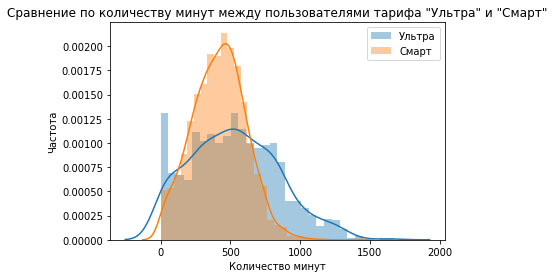

In [80]:
sns.distplot(all_ultra['Количество минут'],bins=30)
sns.distplot(all_smart['Количество минут'],bins=30)
plt.title('Сравнение по количеству минут между пользователями тарифа "Ультра" и "Смарт"')
plt.xlabel('Количество минут')
plt.ylabel('Частота')
plt.legend(['Ультра','Смарт'])
plt.show()

##### Вывод
1. Пользователи тарифа Ультра разговаривают в пределах своего тарифа и редко даже использую все 3000 минуты, основная часть использует половину предоставленного времени. Кто-то даже вообще умудряется не использовать минуты.
2. Пользователи тарифа Смарт в основном находятся в верхних пределах предоставленных минут разговора и часто выходят за лимит.

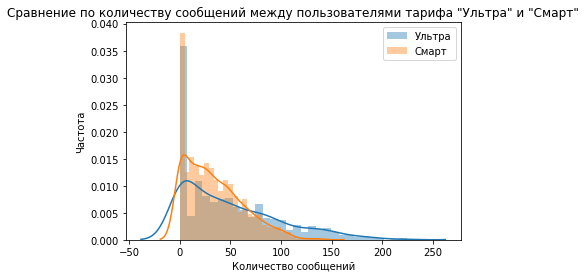

In [81]:
sns.distplot(all_ultra['Количество сообщений'],bins=30)
sns.distplot(all_smart['Количество сообщений'],bins=30)
plt.title('Сравнение по количеству сообщений между пользователями тарифа "Ультра" и "Смарт"')
plt.xlabel('Количество сообщений')
plt.ylabel('Частота')
plt.legend(['Ультра','Смарт'])
plt.show()

##### Вывод
1. Пользователи тарифа Ультра мало отправляют СМС, их показатели варьируются от 0 до ~70. Скорее всего чаще пользуются мессенджерами. Все 1000 сообщений вообще не использются.
2. Пользователей тарифа Смарт можно отметить некоторой динамикой - также много 0 показателей, большое количество находится в рамках лимита в 50 сообщений, но также есть некоторое количество, кто выходит за рамки лимита.

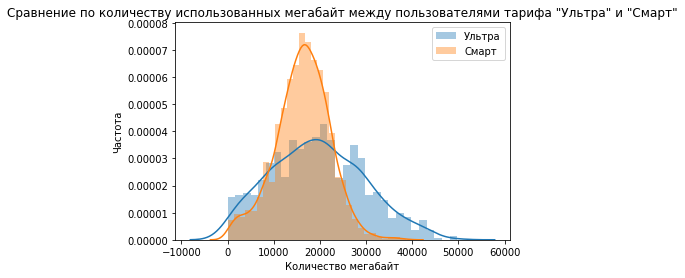

In [82]:
sns.distplot(all_ultra['Количество мегабайт'],bins=30)
sns.distplot(all_smart['Количество мегабайт'],bins=30)
plt.title('Сравнение по количеству использованных мегабайт между пользователями тарифа "Ультра" и "Смарт"')
plt.xlabel('Количество мегабайт')
plt.ylabel('Частота')
plt.legend(['Ультра','Смарт'])
plt.show()

##### Вывод
1. Пользователи тарифа Ультра в основном находятся в своем диапозоне 30 гб (в основном используют до 20 гб), но частенько заходят за лимит.
2. Пользователи тарифа Смарт находятся в пиковых значениях с Интернет трафиком, многие выходят за пределы лимита.

 ### Общие количественные показатели:

In [83]:
print('Общие показатели для тарифа Ультра:')
print(' ')
print('Средние значения по Интернет трафику:', mean_ultra['Среднее количество мегабайт'].sum())
print('Дисперсия по Интернет трафику:', mean_ultra['Дисперсия мб'].sum())
print('Отклонения по Интернет трафику:', mean_ultra['Отклонение мб'].sum())
print(' ')
print('Средние значения по Минутам:', mean_ultra['Среднее количество минут'].sum())
print('Дисперсия по Минутам:', mean_ultra['Дисперсия минут'].sum())
print('Отклонения по Минутам:', mean_ultra['Отклонение в минутах'].sum())
print(' ')
print('Средние значения по Сообщениям:', mean_ultra['Среднее количество сообщений'].sum())
print('Дисперсия по Сообщениям:', mean_ultra['Дисперсия сообщений'].sum())
print('Отклонения по Сообщениям:', mean_ultra['Отклонение сообщений'].sum())
print('_________')
print('Общие показатели для тарифа Смарт:')
print(' ')
print('Средние значения по Интернет трафику:', mean_smart['Среднее количество мегабайт'].sum())
print('Дисперсия по Интернет трафику:', mean_smart['Дисперсия мб'].sum())
print('Отклонения по Интернет трафику:', mean_smart['Отклонение мб'].sum())
print(' ')
print('Средние значения по Минутам:', mean_smart['Среднее количество минут'].sum())
print('Дисперсия по Минутам:', mean_smart['Дисперсия минут'].sum())
print('Отклонения по Минутам:', mean_smart['Отклонение в минутах'].sum())
print(' ')
print('Средние значения по Сообщениям:', mean_smart['Среднее количество сообщений'].sum())
print('Дисперсия по Сообщениям:', mean_smart['Дисперсия сообщений'].sum())
print('Отклонения по Сообщениям:', mean_smart['Отклонение сообщений'].sum())
print('_________')
print('Выручка по тарифу Ультра в месяц:', all_ultra['Выручка в рублях'].mean())
print('Выручка по тарифу Смарт в месяц:', all_smart['Выручка в рублях'].mean())
print('_________')
print('Выручка по тарифу Ультра в год:', all_ultra['Выручка в рублях'].sum())
print('Выручка по тарифу Смарт в год:', all_smart['Выручка в рублях'].sum())
print('_________')
print('Количество пользователей по тарифу Ультра:{}'. format(len(all_ultra.groupby('User_id'))))
print('Количество пользователей по тарифу Смарт:{}'. format(len(all_smart.groupby('User_id'))))

Общие показатели для тарифа Ультра:
 
Средние значения по Интернет трафику: 218673.41473440453
Дисперсия по Интернет трафику: 1167267313.069915
Отклонения по Интернет трафику: 117743.78910786293
 
Средние значения по Минутам: 5951.211721949552
Дисперсия по Минутам: 1137440.4734116723
Отклонения по Минутам: 3684.592431057283
 
Средние значения по Сообщениям: 524.5797940976629
Дисперсия по Сообщениям: 22960.8753479612
Отклонения по Сообщениям: 516.6503945319841
_________
Общие показатели для тарифа Смарт:
 
Средние значения по Интернет трафику: 180932.2878164383
Дисперсия по Интернет трафику: 404217515.1898707
Отклонения по Интернет трафику: 69530.62057147452
 
Средние значения по Минутам: 4641.12598446824
Дисперсия по Минутам: 404639.36272109434
Отклонения по Минутам: 2199.765006356884
 
Средние значения по Сообщениям: 376.9585279330266
Дисперсия по Сообщениям: 8579.658814905659
Отклонения по Сообщениям: 317.61957313855544
_________
Выручка по тарифу Ультра в месяц: 2071.0659898477156
В

### Вывод по Шагу №3:
1. На графиках видно, что больше всего услуг связи потребляют пользователи тарифа "Смарт", они же часто заходят за лимиты по Интернет трафику, и меньше по минутам. За счет их активности и частой не хватки изначальных услуг, они всё больше докупают услуги. В общегодовой перспективе Смарт приносит больше выручки, т.к. пользователей больше (350>148).
2. Также пользователи тарифа "Смарт" практически всегда (не считая трех первых месяцев) потребляют сверх лимита по минутам.
3. Сообщения у всех пользователей не такая активная услуга, даже 50% от предложенных количества сообщений не реализуется. - эпоха мессенджеров.
    * Думаю СМС используется для быстрых ответов на сброс вызова или технологий аутентификации.
4. Есть пользователи "Ультра" которые вообще не пользуются звонками.

# Шаг 4. Гипотезы.

## Гипотеза 1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Для проверки гипотезы нужно принять стандартную нулевую гипотезу (Г0) о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается. Альтернативная гипотеза (АГ) - среднее значение выручки Ультра меньше предполагаемого значения Смарт.

In [84]:
# Пороговое значение alpha
alpha=0.05

### Нулевая гипотеза
1. сначала найду средние показатели выручки ультра + дисперсия.
2. Найду сколько значений попадает в интервал.
3. Найду аналогичные показатели для тарифа смарт.

##### Тариф "Ультра"

In [85]:
ultra = common_numbers.query('Тариф=="ultra"')

In [86]:
# средние показатели выручки
ultra['Выручка в рублях'].mean()

2071.0659898477156

In [87]:
# Показатели дисперсии
disp_ultra=np.var(ultra['Выручка в рублях'])
print(disp_ultra)

143345.5641732588


###### Интервал значений.

In [88]:
print('Больше всего значений попадают с интервал:',round(3*np.sqrt(disp_ultra)),'от среднего значения в рублях:',round(ultra['Выручка в рублях'].mean()))

Больше всего значений попадают с интервал: 1136 от среднего значения в рублях: 2071


In [89]:
st.t.interval(0.95, len(ultra['Выручка в рублях'])-1, loc=np.mean(ultra['Выручка в рублях']), scale=st.sem(ultra['Выручка в рублях']))

(2047.380782538797, 2094.751197156634)

##### Тариф "Смарт"

In [90]:
smart = common_numbers.query('Тариф=="smart"')

In [91]:
# средние показатели выручки
smart['Выручка в рублях'].mean()

1294.6393001345896

In [92]:
# Показатели дисперсии
disp_smart=np.var(smart['Выручка в рублях'])
print(disp_smart)

673628.974426787


##### Интервал значений.

In [93]:
print('Больше всего значений попадают с интервал:',round(3*np.sqrt(disp_smart)),'от среднего значения в рублях:',round(smart['Выручка в рублях'].mean()))

Больше всего значений попадают с интервал: 2462 от среднего значения в рублях: 1295


In [94]:
st.t.interval(0.95, len(smart['Выручка в рублях'])-1, loc=np.mean(smart['Выручка в рублях']), scale=st.sem(smart['Выручка в рублях']))

(1260.5406748523058, 1328.7379254168734)

##### Дисперсии выручки.

In [95]:
ultra['Выручка в рублях'].var()

143491.24055961374

In [96]:
smart['Выручка в рублях'].var()

673931.3213632443

### Проверю гипотезу:

In [97]:
result = st.ttest_ind(ultra['Выручка в рублях'],smart['Выручка в рублях'],equal_var = False)
print('P-value:',result.pvalue)
if (result.pvalue<alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилость отвергнуть нулевую гипотезу')

P-value: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


#### Вывод: гипотеза отвергнута: значения средней выручки тарифа Ультра и тарифа Смарт различаются

### Альтернативная гипотеза.

In [98]:
alpha=0.05

In [99]:
need_numbers = ultra['Выручка в рублях'].mean()
result=st.ttest_1samp(smart['Выручка в рублях'],need_numbers)
print('P-value:',result.pvalue/2)
if (result.pvalue/2<alpha) and (smart['Выручка в рублях'].mean()<=need_numbers):
     print('Отвергаем альтернативную гипотезу')
else:
    print('Не получилость отвергнуть альтернатвную гипотезу')

P-value: 7.16947855739e-312
Отвергаем альтернативную гипотезу


In [100]:
print('Выручка по тарифу Ультра в месяц:', all_ultra['Выручка в рублях'].mean())
print('Выручка по тарифу Смарт в месяц:', all_smart['Выручка в рублях'].mean())

Выручка по тарифу Ультра в месяц: 2071.0659898477156
Выручка по тарифу Смарт в месяц: 1294.6393001345896


#### Вывод: нулевую гипотезу отвергнуть не удалось:
Среднемесячная выручка с тарифа Ультра ожидаемо больше, даже при условии, что пользователи тарифа Смарт чаще вылезают за пределы лимита.



## Гипотеза 2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
Г0- редняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

In [101]:
moscow_all=common_numbers.query('Город=="Москва"')


In [102]:
other_all=common_numbers.query('Город!="Москва"')

In [103]:
# Пороговое значение alpha
alpha=0.05

In [104]:
# Показатели дисперсии в Москве
moscow_all['Выручка в рублях'].var()

566183.0292184273

In [105]:
# средние показатели выручки по Москве
moscow_all['Выручка в рублях'].mean()

1550.8052373158755

In [106]:
# Показатели дисперсии в других регионах
other_all['Выручка в рублях'].var()

656766.5955122438

In [107]:
# средние показатели выручки в других регионах
other_all['Выручка в рублях'].mean()

1528.3169419900116

In [108]:
result=st.ttest_ind(moscow_all['Выручка в рублях'],other_all['Выручка в рублях'],equal_var = False)
print('P-value:',result.pvalue)
if (result.pvalue<alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилость отвергнуть нулевую гипотезу')

P-value: 0.5126564657748214
Не получилость отвергнуть нулевую гипотезу


##### Вывод: средняя выручка между Москвой и регионами не различается.

Их различие не существенно: в 25 рублей.

In [109]:
print('Средняя выручка по пользователю в месяц в Москве: {:.2f}'.format (moscow_all['Выручка в рублях'].mean()))
print('Средняя выручка по пользователю в месяц в Регионах: {:.2f}'.format (other_all['Выручка в рублях'].mean()))

Средняя выручка по пользователю в месяц в Москве: 1550.81
Средняя выручка по пользователю в месяц в Регионах: 1528.32


### Вывод по шагу №4:
1. Были выдвинуты три гипотезы:
    1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различается - подтвердилась.
    2. Средняя выручка "Смарт" больше "Ультра" - не подтвердилась - хоть пользователей Смарт больше, но абонентской плату больше платят пользователи Ультра.
    3. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов - не подтвердилась - их различие не существенно в 25 рублей.
2. Были использованы методы:
    * В первой и третьей гипотезах: Гипотеза о равенстве средних двух генеральных совокупностей с методом: st.ttest_ind
    * Во второй гипотезе: Формулирование односторонних гипотез с методом: st.ttest_1samp
3. Использование equal_var = False обусловлено сильной разницей в дисперсии данных.      
    

# Шаг 5. Общий вывод.
1. Были приведены данные к нужным типам и были исправлены ошибки / заполнены пропуски.
2. Были посчитаны количественные характеристики каждого вида связи для каждого пользователя. + посчитана помесячная выручка.
3. Описаны предпочтения в услугах пользователей для каждого вида связи:
    * Ультра:
        * разговаривают в пределах своего тарифа и редко даже использую все 3000 минуты, основная часть использует половину предоставленного времени. 
        * даже 50% от предложенных количества сообщений не реализуется. Сообщения заканчиваются на дисапазоне 250 в месяц и то самые активные всплески до 50 и до ~80.
        * Интернетом пользуются активно, некоторым даже не хватает изначальных 30 гб.
    * Смарт:
        * Звонки находятся в своих пределах.
        * Сообщения также не популярны.
        * Пользователи всегда выходят за пределы лимита (от 15.1 до 18 гб) - пиковый месяц: декабрь.
4. Пользователей Смарт больше, чем пользователей Ультра (350>148), в среднем в месяц больше выручки с пользователей Ультра (2071>1294)(высокая абонетская плата). Но в общегодовой перспективе пользователи Смарт приносят больше выручки засчет "докупок" услуг связи, т.к. Интернета и Минут не хватает.    
5. Через гипотезы прешл к вывовдам:
    * Средняя выручка Ультра и Смарт различается (у Ультра больше).
    * Разница выручки между Москвой и регионами ничтожно мала (в 25 рублей), что ее практически нет.
6. Сообщения малоиспользуемый вид связи. То количество сообщений, что имеют пользователи Ультра не реализуется даже на 50%. 


### Рекомендации:
1. Ввести новый смежный тариф, что-то среднее между Смарт и Ультра для тех, кто не готов платить такую Аб. плату как для Ультра, но услуг Смарт не хватает.
2. Ввести возможность "перекидывать" услуги, т.е. если не хватает Мегабайт, жертвовать сообщениями. (нужно продумать конвертационный коэффициент, чтобы не было убыточно).
3. Через рекламу побуждать людей переходить на Ультра, т.к. это "позволит" им меньше тратится на доп. услуги.